# Exercise 3

In these week's exercises you will practice Poissonian statistics, delve deeper into the meaning of the error matrix and see an example of a case in which the standard error propagation formula is not directly applicable.

For the first exercise you should install the package *tqdm* from the Anaconda navigator. It provides a progress bar, which is nice to have when a long computation is running.

## 1. Poisson statistics
This exercise is about two variants of a counting experiment: in the first, simpler case, we will see that the observations are well described by a Poisson distribution. In the second case we will have events which are not independent from each other and we will see that the results deviate from a Poisson distribution.

Consider a beam of particles impinging on a thin target. Most particles will go through the target without interacting, while a few will be absorbed. The target is connected to a detector, which fires a signal when a particle is absorbed by the target. In the first part of the exercise we assume to have a perfect detector: it is able to detect each and every particle hitting the target.

The experiment consists in counting how many particles are absorbed by the target in a fixed time interval, e.g. 1s. We will repeat the counting *n* times and see how the results are distributed.

To simulate the setup, assume the following numbers:<br>
- Number of particles arriving at the target per second
- Probability that a particle is absorbed by the target


In [1]:
''' Let's start by importing some useful modules and functions...'''
from numpy.random import rand
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
# conda install tqdm
from tqdm import tqdm_notebook as tqdm # Nice progress bar for long computations
%matplotlib inline 

''' Definition of relevant parameters of the experiment
    (feel free to change the values and see how the result changes)'''

particle_rate = 1e6             # Number of particles arriving at the target per second
delta_t = 1                     # duration of one experiment in seconds
absorption_probability = 2e-6   # Probability that a particle is absorbed by the target
n_trials = 1000                  # How many times you repeat the experiment

### Detection
Write a function which decides if a single particle is absorbed by the target (return True) or not (return False).

Hint: generate a uniformly distributed random number between 0 and 1 with the *rand()* function. Use it do decide if the particle is detected or not, based on the known *absorption_probability*.

**1a) Theory**

In [2]:
# TODO: implement the function
""" :param: absorption_probability"""

def particles_were_detected(p=absorption_probability, n=1):
    """ decide wheather or not a particle was detected
        :param p : absorption_probability
        :param n : number of tries
        :returns: particle was detected
        :rtype: numpy.ndarray dtype=bool """
    return rand(int(n)) <= p


### Experiment
Now write a function to simulate the experiment running for a time *delta_t*. It should do the following:
- compute how many particles reach the target during *delta_t* with the known *particle_rate*,
- for each of those check if they get absorbed or not (cf. *particle_is_detected()*),
- return the number of particles which are absorbed by the target during *delta_t*.

**1b) Setup**

In [3]:
# TODO: implement the function
# def run_experiment(...):
def run_experiment(t=delta_t, r=particle_rate, p=absorption_probability):
    """ runs the experiment: particles from a beam are detected after passing an absorber
        :param t [s] : time the experiment is running
        :param r [1/s]: particle rate of the beam 
        :param p : absorption_probability
        :returns: number of detected particles """
    n = t * r
    return np.count_nonzero(particles_were_detected(p, n))


You are now ready to run the experiment, i.e. run the function. Do this a few times to get a feeling for the results: is the number of counted particles the same every time or does it change? What kind of result do you expect from the chosen *particle_rate, delta_t* and *absorption_probability*?

In [4]:
# TODO: run the experiment and play around with the parameters
for i in range(10):
    print(run_experiment())

4
1
2
5
2
1
1
1
4
1


Let's now analyse the results more systematically: run the experiment *n_trials* times and save the results in a list or array. Depending on your computer, this might take some time.

**1c) Analysis**

In [5]:
# TODO: get familiar with the progress bar

def get_results(f, n=n_trials):
    progress_bar = tqdm(total=n_trials, unit=' trials')
    results = []
    for i in range(n_trials):
        results.append(f())
        progress_bar.update()
    return results

results = get_results(run_experiment)

Before plotting the results in a histogram, let's define the expected Poisson distribution in order to make a comparison. If you are not sure how to do this, have a look at last week's exercise. What is the expected *mu* paramter for the given *particle_rate, delta_t* and *absorption_probability*?

In [6]:
# TODO: define the mu parameter of the poissonian using particle_rate, delta_t and absorption_probability.
#       create arrays in order to plot the distribution
mu = particle_rate * delta_t * absorption_probability
x = np.arange(0, 20)
y = poisson.pmf(x, mu)


Now plot the results of the experiment together with the parent distribution. Again, have a look at last week's exercise if you need help. When plotting the histogram remember to set *density=True* in order to have it normalized to unity for a meaningful comparison with the Poisson distribution (if this option does not work, which might be the case for older versions, try replacing it with *normed=True*).

**1d) Results**

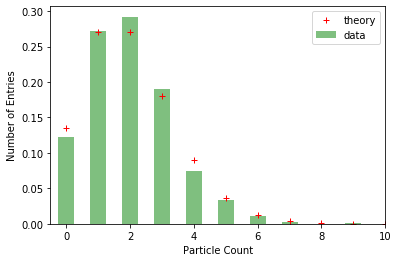

In [8]:
# TODO: compare the results with the expected distribution
#       draw a histogram for the measurements
#       draw a plot with the theoretical expectation
fig, ax = plt.subplots()
ax.hist(results, color='g', alpha=.5, bins=10, range=(-0.5,9.5), label='data', density=True, rwidth=0.5)
ax.plot(x, y, 'r+', label='theory') # plot of the Poisson distribution
ax.set(xlabel='Particle Count', ylabel='Number of Entries', xlim=(-.5, 10))
plt.legend()

What do you observe? Is the data from the experiment well described by the Poisson distribution?

Let's now make a different assumption about the detector: it has no longer perfect efficiency, but whenever it detects a particle it needs some time to process the signal. Durign this time the detector is blind to any particle which might be absorbed by the target. In this way the recorded particles are not independent from each other anymore, and as you will see this will cause the result of the experiment to deviate from a Poisson distribution.

Modify your implementation of the function *run_experiment()* in order to account for the dead time of the detector. Assume that whenever the detector records a particle it is blind to the next 500000 particles reaching the target.

In [9]:
dead_time = .2  # in seconds

# TODO implement the function.
def run_experiment_with_dead_time(t=delta_t, r=particle_rate, p=absorption_probability, td=dead_time):
    """ runs the experiment: particles from a beam are detected after passing an absorber including a detector dead time
        :param t [s] : time the experiment is running
        :param r [1/s]: particle rate of the beam 
        :param p : absorption_probability
        :param td [s] : dead time of the detector
        :returns: number of detected particles """
    dead_time_particles = r * td
    n = t * r
    fully_efficient = particles_were_detected(p, n)
    # find events with hits:
    # np.where(condition of x) returns a tuple (array,) of the indices of the given array x fullfilling the condition
    hit_events = np.where(fully_efficient)[0]
    detected_hits = [hit_events[0]] if hit_events.size else []
    for event in hit_events:
        if event > detected_hits[-1] + dead_time_particles:
            detected_hits.append(event)
    return np.count_nonzero(detected_hits)


Get the results.

In [10]:
# TODO: run the function n_trials times and save the results as before
new_results = get_results(run_experiment_with_dead_time)

Plot the new results with detector dead time together with the same Poisson distribution from before. What do you observe?

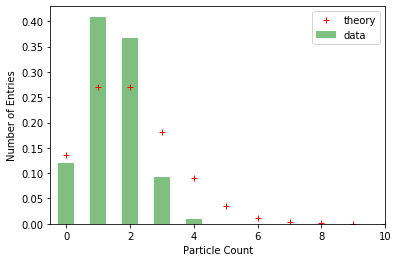

In [11]:
# plt.hist(...) # histogram for the measurements
# plt.plot(...) # plot of the Poisson distribution
# plt.xlabel('Counted particles')
# plt.legend()
fig, ax = plt.subplots()
ax.hist(new_results, color='g', alpha=.5, bins=10, range=(-0.5,9.5), label='data', density=True, rwidth=0.5)
ax.plot(x, y, 'r+', label='theory') # plot of the Poisson distribution
ax.set(xlabel='Particle Count', ylabel='Number of Entries', xlim=(-.5, 10))
plt.legend()


## 2. Correlated variables and error matrix

In this exercise you will work on a pair of correlated variables, compute the error matrix and visualize the error ellipse. 

### Uncorrelated data
Let's start from the case of two uncorrelated variables, saved in the file *data_uncorrelated.txt*. Have a look at the file: each line represents one measurement, the first number being the value of the *x* variable and the second number the value of the *y* variable.

In [12]:
data_uncor = np.genfromtxt('data_uncorrelated.txt')
x, y = data_uncor[:, 0], data_uncor[:, 1]
print(data_uncor[:10])

[[ 1.76  0.12]
 [ 0.95  0.87]
 [ 0.2  -0.09]
 [-1.17 -0.79]
 [ 1.75  0.78]
 [ 3.23  0.06]
 [ 2.26  1.88]
 [-0.54  0.42]
 [-2.66  0.57]
 [-4.13 -0.52]]


Plotting the data. 
How can you recognise that *x* and *y* are not correlated? Compare the 2D distribution in the *xy* plane and the histograms of the *x* and *y* values. What do you notice about e.g. the range of the axes and the position of the means?

[Text(0, 0.5, 'Number of Entries'), (-7, 7), Text(0.5, 0, '$y$')]

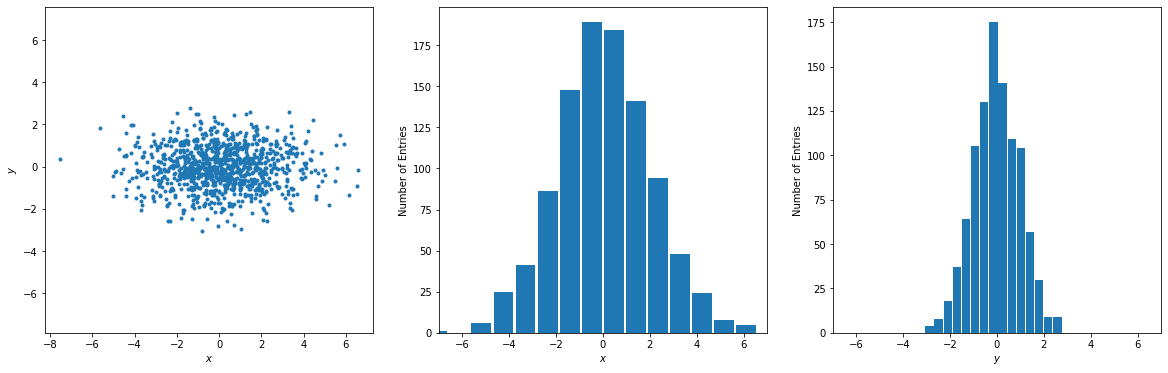

In [15]:
f, ax = plt.subplots(1,3, figsize=(20, 6))
ax = ax.flatten()

def plot_data(ax, data, name='uncorrelated data'):
    ax.plot(data[:, 0], data[:, 1], '.', label=name)
    ax.set(xlabel=r'$x$', ylabel=r'$y$')
    ax.axis('equal')  # equal ranges on both x- and y-axis
    
plot_data(ax[0], data_uncor)

ax[1].set_xlabel(r'$x$')
ax[1].hist(x, bins=15, rwidth=.9)
ax[1].set(xlabel=r'$x$', ylabel='Number of Entries', xlim=(-7,7))

ax[2].hist(y, bins=15, rwidth=.9)
ax[2].set(xlabel=r'$y$', ylabel='Number of Entries', xlim=(-7,7))

**2a) Covariance matrix**

Compute the covariance matrix. You can either write a function to do this yourself, or use the numpy implementation.\
*Hint*: Have a look at last week's exercise if you feel lost.

In [16]:
# TODO compute the covariance matrix for uncorrelated data and print the result
covariance_matrix = np.cov(x, y)
print('covariance matrix:\n {}'.format(covariance_matrix))

covariance matrix:
 [[4.099275   0.00861456]
 [0.00861456 0.98350056]]


Compare your result with the error matrix you expect for two uncorrelated variables, cf. slides from Lecture 3: $\text{diag}(\sigma_x^2,\sigma_y^2)$. Is your result compatible with this expression?

**2b) Eigenvectors and eigenvalues**

We will now compute the eigenvectors and eigenvalues of the covariance matrix and interpret them in terms of the properties of the distributions we just saw. As before, you can compute the values yourself or use the numpy implementation\
*Hint: np.linalg.eig(matrix)*

In [17]:
# TODO compute the eigenvalues and eigenvectors of the covariance matrix and print the result
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
print('eigenvalues:\n {}\n'.format(eigenvalues))
print('eigenvectors:\n {}'.format(eigenvectors))


eigenvalues:
 [4.09929882 0.98347674]

eigenvectors:
 [[ 0.99999618 -0.00276479]
 [ 0.00276479  0.99999618]]


For this easy case of uncorrelated variables you should recognize the following: the eigenvectors are aligned with the $x$ and $y$ axes and the eigenvalues are the variances of the data along the same axes; this means that the standard deviation in the $x$ and $y$ directions are the square root of the respective eigenvalue. Keep this in mind, as we will later see what changes if the variables are correlated.

**2c) Visualisation**

For a visual interpretation do the following: plot again the 2D distribution of the data together with the eigenvectors multiplied by the square root of the corresponding eigenvalue (in this way the length of the vector will be the corresponding standard deviation).

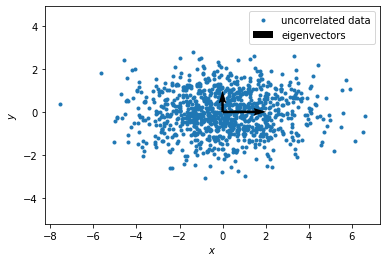

In [18]:
fig, ax = plt.subplots()
plot_data(ax, data_uncor)

# TODO: compute the eigenvectors with the length of the standard deviation

sigma_x, sigma_y = np.sqrt(eigenvalues)
v1_x, v1_y = eigenvectors[:, 0] * sigma_x
v2_x, v2_y = eigenvectors[:, 1] * sigma_y

# Draw the vectors. The options are needed to draw them in the correct size, zorder sets what is plotted first
ax.quiver(v1_x, v1_y, angles='xy', scale_units='xy', scale=1, zorder=3, label='eigenvectors')  
ax.quiver(v2_x, v2_y, angles='xy', scale_units='xy', scale=1, zorder=3)
ax.legend()

Let's now draw an ellipse with half-axes $\sigma_x$ and $\sigma_y$: this is the equivalent of the $1 \sigma$ interval for a 1D Gaussian distribution.

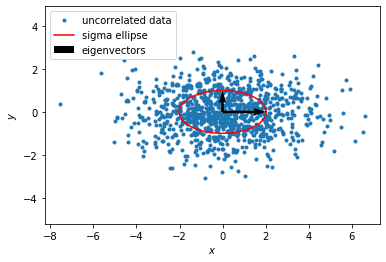

In [19]:
fig, ax = plt.subplots()
plot_data(ax, data_uncor)

phi = np.linspace(0, 2 * np.pi)
ellipse_x = sigma_x * np.cos(phi) # x-coordinates of the points on the ellipse
ellipse_y = sigma_y * np.sin(phi) # y-coordinates of the points on the ellipse

ax.plot(ellipse_x, ellipse_y, 'r', zorder=2, label='sigma ellipse')

ax.quiver(v1_x, v1_y, angles='xy', scale_units='xy', scale=1, zorder=3, label='eigenvectors')
ax.quiver(v2_x, v2_y, angles='xy', scale_units='xy', scale=1, zorder=3)
ax.legend()

### Correlated data

Let us now look at the case of two correlated measurements. Load the data from *data_correlated.txt* and repeat the steps from above up to the drawing of the vectors; do not draw the ellipse yet, we will do that in the next step. You should be able to copy-paste most of the code from the uncorrelated case.

**2d Compute variables**

In [20]:
data_cor = np.genfromtxt('data_correlated.txt')
xc, yc = data_cor[:, 0], data_cor[:, 1]

cov_matrix = np.cov(xc, yc)
eigvals, eigvecs = np.linalg.eig(cov_matrix)

print('covariance matrix:\n {}\n'.format(cov_matrix))
print('eigenvalues:\n {}\n'.format(eigvals))
print('eigenvectors:\n {}'.format(eigvecs))


covariance matrix:
 [[4.28025115 1.05488699]
 [1.05488699 0.97933877]]

eigenvalues:
 [4.58856809 0.67102183]

eigenvectors:
 [[ 0.95984293 -0.28053796]
 [ 0.28053796  0.95984293]]


You should now see that the eigenvectors are not aligned with the coordinate axes anymore. However, as before, the eigenvectors represent the direction of the largest spread of the data, and the eigenvalues, i.e. the variances, define how large this spread is.

Now we plot the data.

[Text(0, 0.5, 'Number of Entries'), (-7, 7), Text(0.5, 0, '$x$')]

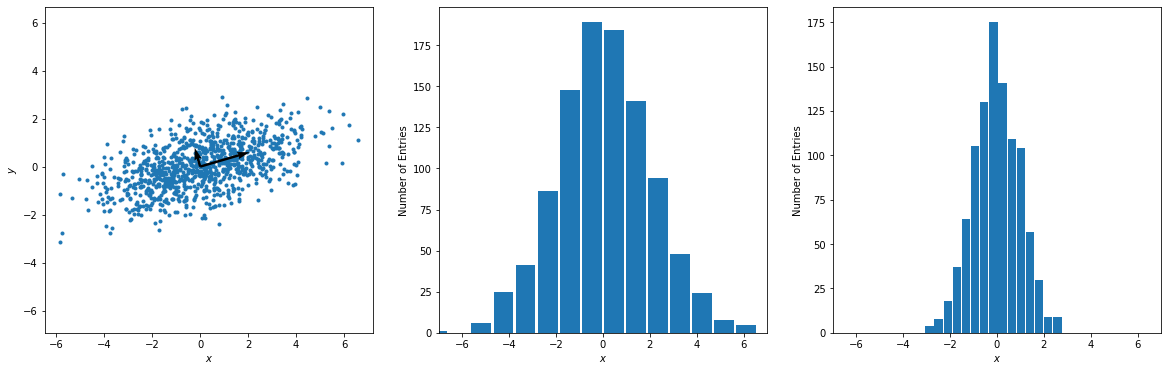

In [21]:
f, ax = plt.subplots(1,3, figsize=(20, 6))
ax = ax.flatten()
    
plot_data(ax[0], data_cor, 'correlated data')

sigma = np.sqrt(eigvals)
x1, x2, y1, y2 = (eigvecs * sigma).flatten()
ax[0].quiver(x1, y1, angles='xy', scale_units='xy', scale=1, zorder=3, label='eigenvectors')  
ax[0].quiver(x2, y2, angles='xy', scale_units='xy', scale=1, zorder=3)

ax[1].set_xlabel(r'$x$')
ax[1].hist(x, bins=15, rwidth=.9)
ax[1].set(xlabel=r'$x$', ylabel='Number of Entries', xlim=(-7,7))

ax[2].hist(y, bins=15, rwidth=.9)
ax[2].set(xlabel=r'$x$', ylabel='Number of Entries', xlim=(-7,7))

**2d) Ellipse**

Let's now draw the ellipse. There are different ways in which this can be done. Let's start by determining the angle of rotation *theta*.

In [22]:
# TODO: compute the angle of rotation (angle between eigenvector and axis)
theta = np.arctan(y1 / x1)
print('theta = {:1.2f}°'.format(np.rad2deg(theta)))

theta = 16.29°


To draw the rotated ellipse, define the $x$ and $y$ coordinates as before, and than rotate them by multiplying them with a rotation matrix:
$ R={\begin{bmatrix}\cos \theta &-\sin \theta \\\sin \theta &\cos \theta \\\end{bmatrix}}$.

*Hint: np.dot*

In [23]:
phi = np.linspace(0, 2 * np.pi)
ellipse_x = sigma[0] * np.cos(phi) # x-coordinates of the points on the ellipse
ellipse_y = sigma[1] * np.sin(phi) # y-coordinates of the points on the ellipse

# TODO: compute the rotated ellipse with a rotation matrix

rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
ellipse = np.dot(rotation_matrix, [ellipse_x, ellipse_y]) 


Now we are ready to plot everything together.

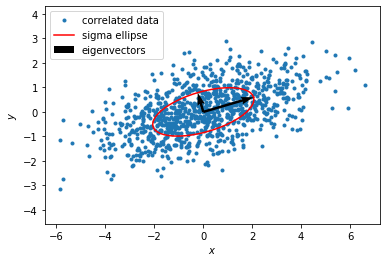

In [24]:
fig, ax = plt.subplots()
plot_data(ax, data_cor, 'correlated data')

ax.quiver(x1, y1, angles='xy', scale_units='xy', scale=1, zorder=3, label='eigenvectors')  
ax.quiver(x2, y2, angles='xy', scale_units='xy', scale=1, zorder=3)

ax.plot(ellipse[0], ellipse[1], 'r', label='sigma ellipse')
ax.legend()

### Bonus

The data for this exercise has been generated with the following code. Feel free to change the parameters and rerun the exercise.

In [25]:
import numpy as np

n_samples = 1000
mu = np.array([0.,0.])
var_x = 4.
var_y = 1.
cov_xy = 1.
r = np.array([
        [  var_x, cov_xy,],
        [ cov_xy,  var_y,]
    ])

y = np.random.multivariate_normal(mu, r, size=n_samples)

with open('output.txt', 'w') as outfile:
    np.savetxt(outfile, y, fmt='%3.2f')

## 3. Computing uncertainties on inefficiencies

Consider an imperfect particle detector: out of all the particles hitting the detector, a fraction passes through unnoticed. The efficiency of the detector, i.e. the fraction of particles which are detected, is a very important parameter for any experimental setup. Suppose you want to measure the efficiency of a new detector. A possible approach is the following: you shoot $n$ particles on the detector, and count the number of signals $k$ which are recorded. The efficiency is then given by $\varepsilon = k\,/\,n$. What is the uncertainty on this quantity? As a first approach, let's assume that $k$ and $n$ are Poisson distributed (and thus $\delta k = \sqrt{k}$ and $\delta n = \sqrt{n}$) and that we can apply the standard error propagation formula you saw in lecture 1:
$$ \delta f = \sqrt{ \sum_{i=1}^N \left(\left. \frac{\partial f}{\partial x_i}\right\vert_{x_i=x_i^0} \delta x_i \right)^2}. $$
- Show that this formula yields the following result:
$$ \delta \varepsilon = \sqrt{\frac{k}{n^2} + \frac{k^2}{n^3}}. $$

What happens to the uncertainty for *extreme* values of $k$, i.e. $k=0$ and $k=n$? Do these results make sense? Remember that the efficiency is by definition a number between 0 and 1.

The source of the problem is that $k$ and $n$ are not independent (the particles which are recorded are a subset of all particles which hit the detector). A way to handle this is noting that the efficiency measurement is in fact a binomial process with total events $n$ and success probability $\varepsilon$ (see slides of Lecture 3).
- Using the known variance of the binomial distribution show that in this case the uncertainty is given by 
$$ \delta \varepsilon = \sqrt{\frac{\varepsilon (1-\varepsilon)}{n}}.$$

An equivalent approach is to consider, instead of the total number of particles $n$, the number $n_f$ of particles which fail to be detected. In this approach, $n = k + n_f$ is not fixed anymore and $k$ and $n_f$ are uncorrelated; thus, the standard error formula is valid.
- Show that applying the standard error formula to $\varepsilon = k\,/\,(k+n_f)$ yields again $$ \delta \varepsilon = \sqrt{\frac{\varepsilon (1-\varepsilon)}{n}}.$$

Note that when evaluating this formula one has to use the measured (estimated) value of $\varepsilon$, since the true value is unknown. This is a good approximation for *intermediate* values of $k$, i.e. $\varepsilon$ not too close to 0 or 1. The exact meaning of *too close* is a matter of judgement - the extreme values $\varepsilon = 0$ and $\varepsilon = 1$ are clearly too close, as they yeld 0 uncertainty which is nonsense.